# Flatiron School Data Science Capstone: Automating the Kansas City Freight Industry
## A Lesson in Machine Learning from Experimentation to Product
---
- Presented by Kevin McPherson
- Date Submitted: July 23, 2020
- Date Presented: July 24, 2020
- Cohort Instructor: Jeff Herman 
---

![The freight industry](https://images.tech.co/wp-content/uploads/2018/08/30083911/Future-of-Trucking-Industry-Automated-Technology-VR.jpg)

## Table of Contents

1. [Overview](#Overview)
2. [Abstract](#Abstract)
3. [The OSEMN Framework](#TheOSEMNFramework)

## Overview
<a id="Overview"></a>
This project seeks to take a seemingly difficult problem for many of the freight and freight-adjacent companies in the Kansas City area: predict the cost of a car or any other type of vehicle regardless of weather, geographic location of pickup and drop-off, and the characteristics of the payload. Due to the current job market in data science, many employers are searching for data scientists who are more "generalists" than pure data scientists, especially at startups. As such, I have chosen to focus on the machine learning operations (**"MLOps"**) of this project as a main driver for my learning in the capstone project. However, I want to make it known that I also have not abandoned the **OSEMN Framework** that the project entails; it is simply a consequence of my current job that not much time is spent *hypothesizing* so a lot of that work is done ad-hoc, as shown in this notebook. 

---

## Abstract
<a id="Abstract"></a>
Due to it's central location in the United States, Kansas City, Missouri is a prime location for not only distribution centers but the freight car industry. It is estimated that because of its location, 85 percent of the US population could be reached within two days of shipping and freight logistics. It is predicted that between 2016 and 2027, the shipping by truck industry will grow by 27 percent; that's growth from an already staggering 796.7 billion total revenue industry (Statista, 2018). As such, the industry demands a smarter solution to price trips before they happen, so that less operational costs can be spent on coordination of resources (logistics) and more money can be put to the salaries of drivers and truck maintenance for optimal running of the supply chain. Thus, in this capstone project, I will introduce a machine learning model that predicts shipping prices on a smaller attainable market: that of the 12 billion per year vehicle shipping services. My goal is to present both supervised (multiple linear regression), unsupervised (clustering), and ensemble (random forest regressor) learning models and deploy one of them to a requestable API used the FastAPI and Cortex technologies, which have been recently developed, and to deploy a useable model for a company called SuperDispatch which will use this API in their ShipperTMS and CarrierTMS platforms to help merchandisers and freight companies, respectfully. **Numberwise, this will take a trans-geographical, multi-person job and shrink it down into a single click.** 

---

## The OSEMN Framework
<a id="TheOSEMNFramework"></a>

![the OSEMN framework](https://miro.medium.com/max/700/1*eE8DP4biqtaIK3aIy1S2zA.png)

For this project, I will be using the OSEMN Framework. OSEMN stands for **Obtain, Scrub, Explore, Model, and iNterpret**. A more detailed description can be found [here](https://towardsdatascience.com/5-steps-of-a-data-science-project-lifecycle-26c50372b492).

---

# Step 1: *O*btain the Data from Relevant Sources

## Import Necessary Libraries

In [1]:
import pandas as pd # For data manipulation
import numpy as np # For statistics, file compression
import missingno as msno # For visualization of data completeness
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import distance
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import the data and assign the columns

In [3]:
df = pd.read_csv('/Users/kevinmcpherson/Bellwethr/superdispatch/bellwethr-orders-export-2020-06-24.csv') # Find the data in the right directory

When initially imported, the data does not have the column names. These column names were given to Bellwethr (place I work) by  the clients (SuperDispatch). 
SuperDispatch has an alpha version of their transport predictor, but Bellwethr was recruited to make a new version. As such, we were constrained to a few
features that they wanted as inputs. Namely, `pickup_latitude`, `pickup_longitude`, `delivery_latitude`, `delivery_longitude` 

In [4]:
df.columns = ['created_at', 'pickup_address', 'pickup_city',
                 'pickup_state', 'pickup_zip', 'pickup_latitude',
                 'pickup_longitude', 'pickup_date', 'delivery_address',
                 'delivery_city', 'delivery_state', 'delivery_zip',
                 'delivery_latitude', 'delivery_longitude',
                 'delivery_date', 'payment_method', 'price',
                 'inspection_type', 'status', 'vehicle_year', 'vehicle_make', 'vehicle_model',
                 'vehicle_type', 'vehicle_price', 'is_inoperable',
                 'requires_enclosed_trailer']

In [5]:
df.head()

created_at     pickup_address pickup_city pickup_state  \
0  2019-06-01 00:00:39.227653+00            Hwy 131     Wayland           MI   
1  2019-06-01 00:00:39.227653+00            Hwy 131     Wayland           MI   
2  2019-06-01 00:00:39.227653+00            Hwy 131     Wayland           MI   
3  2019-06-01 00:00:59.872031+00  1190 Lancaster Rd     manheim           PA   
4  2019-06-01 00:00:59.872031+00  1190 Lancaster Rd     manheim           PA   

  pickup_zip  pickup_latitude  pickup_longitude pickup_date  \
0      35956        42.674468        -85.661096         NaN   
1      35956        42.674468        -85.661096         NaN   
2      35956        42.674468        -85.661096         NaN   
3      17545        40.139694        -76.396820         NaN   
4      17545        40.139694        -76.396820         NaN   

                delivery_address delivery_city  ...   price inspection_type  \
0               12900 US HWY 431          BOAZ  ...  1500.0             NaN   
1               12900 US HWY 431          BOAZ  ...  1500.0             NaN   
2               12900 US HWY 431          BOAZ  ...  1500.0             NaN   
3  25280 Pleasant Valley Rd #100     chantilly  ...   450.0             NaN   
4  25280 Pleasant Valley Rd #100     chantilly  ...   450.0             NaN   

      status  vehicle_year vehicle_make      vehicle_model   vehicle_type  \
0  delivered        2015.0          GMC        Sierra 1500  4_door_pickup   
1  delivered        2017.0     Chrysler                300          sedan   
2  delivered        2016.0          RAM               1500  4_door_pickup   
3  delivered        2014.0         land  rover range rover            suv   
4  delivered        2011.0     maserati       quattroporte          other   

  vehicle_price is_inoperable  requires_enclosed_trailer  
0           NaN             f                          f  
1           NaN             f                          f  
2           NaN             f                          f  
3           NaN             f                          f  
4           NaN             f                          f  

[5 rows x 26 columns]

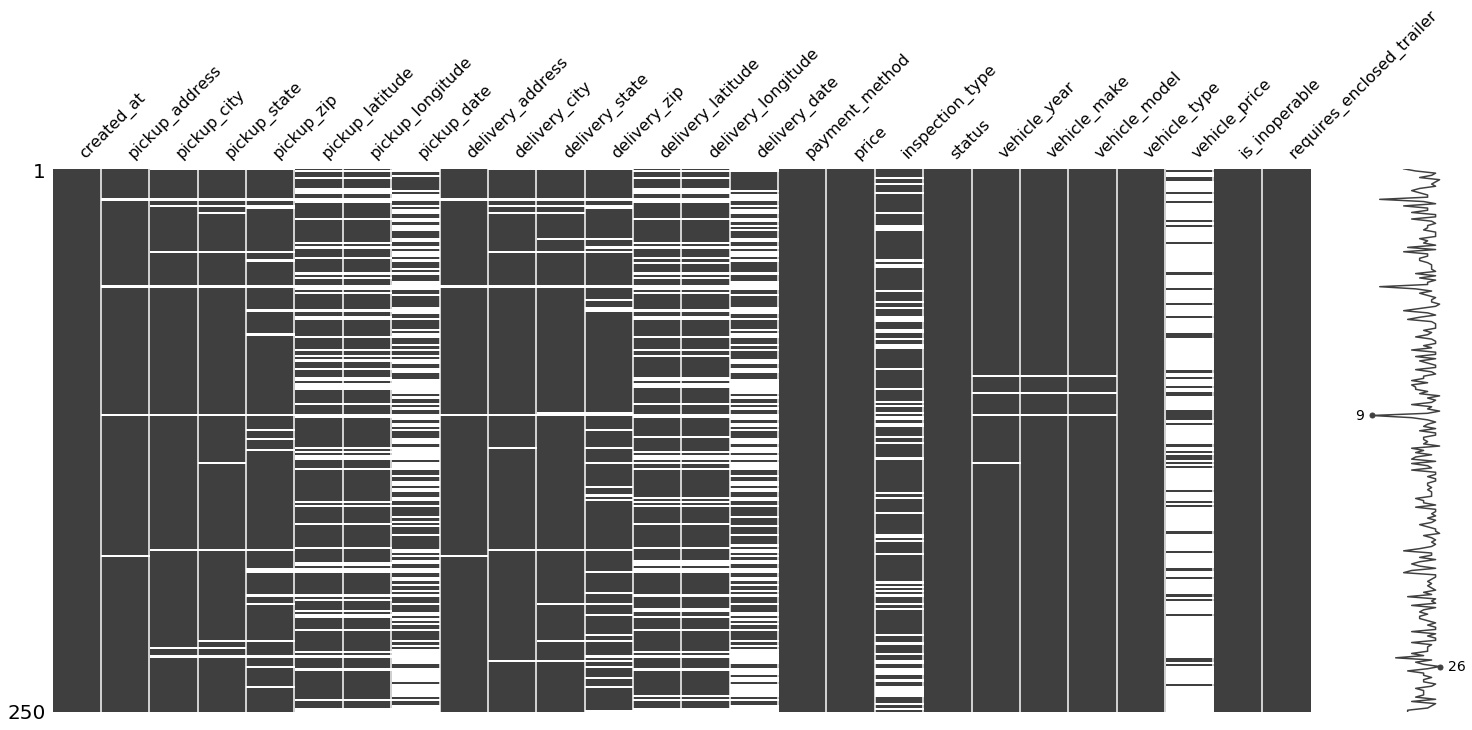

In [5]:
msno.matrix(df.sample(250))

In [6]:
df = df[(df['status'] == 'delivered')]

In [7]:
df.head()

created_at     pickup_address pickup_city pickup_state  \
0  2019-06-01 00:00:39.227653+00            Hwy 131     Wayland           MI   
1  2019-06-01 00:00:39.227653+00            Hwy 131     Wayland           MI   
2  2019-06-01 00:00:39.227653+00            Hwy 131     Wayland           MI   
3  2019-06-01 00:00:59.872031+00  1190 Lancaster Rd     manheim           PA   
4  2019-06-01 00:00:59.872031+00  1190 Lancaster Rd     manheim           PA   

  pickup_zip  pickup_latitude  pickup_longitude pickup_date  \
0      35956        42.674468        -85.661096         NaN   
1      35956        42.674468        -85.661096         NaN   
2      35956        42.674468        -85.661096         NaN   
3      17545        40.139694        -76.396820         NaN   
4      17545        40.139694        -76.396820         NaN   

                delivery_address delivery_city  ...   price inspection_type  \
0               12900 US HWY 431          BOAZ  ...  1500.0             NaN   
1               12900 US HWY 431          BOAZ  ...  1500.0             NaN   
2               12900 US HWY 431          BOAZ  ...  1500.0             NaN   
3  25280 Pleasant Valley Rd #100     chantilly  ...   450.0             NaN   
4  25280 Pleasant Valley Rd #100     chantilly  ...   450.0             NaN   

      status  vehicle_year vehicle_make      vehicle_model   vehicle_type  \
0  delivered        2015.0          GMC        Sierra 1500  4_door_pickup   
1  delivered        2017.0     Chrysler                300          sedan   
2  delivered        2016.0          RAM               1500  4_door_pickup   
3  delivered        2014.0         land  rover range rover            suv   
4  delivered        2011.0     maserati       quattroporte          other   

  vehicle_price is_inoperable  requires_enclosed_trailer  
0           NaN             f                          f  
1           NaN             f                          f  
2           NaN             f                          f  
3           NaN             f                          f  
4           NaN             f                          f  

[5 rows x 26 columns]

# Label encoding, data parsing and other scaling operations

In [8]:
df = df[['pickup_latitude', 'pickup_longitude', 'delivery_latitude', 'delivery_longitude', 'vehicle_year',
        'vehicle_type', 'is_inoperable', 'vehicle_price']]

In [9]:
df = df.dropna(how = 'any', axis = 0)

In [10]:
df.head()

pickup_latitude  pickup_longitude  delivery_latitude  delivery_longitude  \
35        26.233345        -80.205093          26.687171          -80.182647   
36        26.233345        -80.205093          26.687171          -80.182647   
37        26.233345        -80.205093          26.687171          -80.182647   
38        26.233345        -80.205093          26.687171          -80.182647   
39        26.233345        -80.205093          26.687171          -80.182647   

    vehicle_year vehicle_type is_inoperable  vehicle_price  
35        2013.0          suv             f           70.0  
36        2018.0          suv             f           70.0  
37        2014.0        sedan             f           70.0  
38        2008.0          suv             f           70.0  
39        2016.0          suv             f           70.0

In [11]:
df['vehicle_year'] = df['vehicle_year'].astype('int')
df.is_inoperable = df.is_inoperable.eq('f').mul(0)

In [12]:
df.head()

pickup_latitude  pickup_longitude  delivery_latitude  delivery_longitude  \
35        26.233345        -80.205093          26.687171          -80.182647   
36        26.233345        -80.205093          26.687171          -80.182647   
37        26.233345        -80.205093          26.687171          -80.182647   
38        26.233345        -80.205093          26.687171          -80.182647   
39        26.233345        -80.205093          26.687171          -80.182647   

    vehicle_year vehicle_type  is_inoperable  vehicle_price  
35          2013          suv              0           70.0  
36          2018          suv              0           70.0  
37          2014        sedan              0           70.0  
38          2008          suv              0           70.0  
39          2016          suv              0           70.0

# Zip coordinates into one column after parsing through valid coordinates

In [13]:
df['pickup_latitude'] = df['pickup_latitude'].astype('float')
df['delivery_latitude'] = df['delivery_latitude'].astype('float')
df['pickup_longitude'] = df['pickup_longitude'].astype('float')
df['delivery_longitude'] = df['delivery_longitude'].astype('float')

In [14]:
# df['pickup_latitude'] = df[(df['pickup_latitude'] > -90) & (df['pickup_latitude'] < 90)]
# df['delivery_latitude'] = df[(df['delivery_latitude'] > -90) & (df['delivery_latitude'] < 90)]
# df['pickup_longitude'] = df[(df['pickup_longitude'] > -180) & (df['pickup_longitude'] < 180)]
# df['delivery_longitude'] = df[(df['delivery_longitude'] > -180) & (df['delivery_longitude'] < 180)]

In [15]:
df['pickup_coordinates'] = list(zip(df.pickup_latitude,df.pickup_longitude))
df['delivery_coordinates'] = list(zip(df.delivery_latitude,df.delivery_longitude))

# Add a distance feature

In [16]:
from geopy import distance

In [17]:
def gets_distance_miles(row):
    try:
        return distance.great_circle(row['pickup_coordinates'], row['delivery_coordinates']).miles
    except: 
        return ('error')

In [18]:
df['distance']= df.apply(gets_distance_miles, axis=1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/geopy/point.py:405: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)


In [19]:
df.head()

pickup_latitude  pickup_longitude  delivery_latitude  delivery_longitude  \
35        26.233345        -80.205093          26.687171          -80.182647   
36        26.233345        -80.205093          26.687171          -80.182647   
37        26.233345        -80.205093          26.687171          -80.182647   
38        26.233345        -80.205093          26.687171          -80.182647   
39        26.233345        -80.205093          26.687171          -80.182647   

    vehicle_year vehicle_type  is_inoperable  vehicle_price  \
35          2013          suv              0           70.0   
36          2018          suv              0           70.0   
37          2014        sedan              0           70.0   
38          2008          suv              0           70.0   
39          2016          suv              0           70.0   

                   pickup_coordinates       delivery_coordinates distance  
35  (26.233344800000005, -80.2050934)  (26.6871706, -80.1826468)  31.3871  
36  (26.233344800000005, -80.2050934)  (26.6871706, -80.1826468)  31.3871  
37  (26.233344800000005, -80.2050934)  (26.6871706, -80.1826468)  31.3871  
38  (26.233344800000005, -80.2050934)  (26.6871706, -80.1826468)  31.3871  
39  (26.233344800000005, -80.2050934)  (26.6871706, -80.1826468)  31.3871

In [20]:
df['distance'].value_counts()

2.119622      2273
58.940408     1863
52.598743     1309
31.387102     1036
74.546833     1019
              ... 
416.855718       1
302.248299       1
250.834173       1
110.069128       1
189.671352       1
Name: distance, Length: 52852, dtype: int64

In [21]:
df = df[(df['distance'] != 'error')]

# LabelEncode Vehicle Type

In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
X = np.array(df[['vehicle_type']])

In [24]:
X = X.reshape(-1,1)

In [27]:
X = df['vehicle_type']

In [31]:
df[df['vehicle_type'] == 'atv']

pickup_latitude  pickup_longitude  delivery_latitude  \
57225          37.509842        -82.520017          39.542689   
100553         36.863287        -84.224539          39.542689   
108152         35.220014       -111.551970          36.225749   
148922         46.942496        -96.817727          43.204822   
260619         36.732440        -76.238814          40.120595   
...                  ...               ...                ...   
2732476        35.409400        -80.579700          29.651900   
2732477        35.409400        -80.579700          29.651900   
2763412        48.114547        -98.874861          43.204807   
2822394        32.816577        -97.106058          39.812717   
2898608        32.630930        -96.702610          33.674697   

         delivery_longitude  vehicle_year vehicle_type  is_inoperable  \
57225            -84.286378          2017          atv              0   
100553           -84.286378          2016          atv              0   
108152          -115.126567          2015          atv              0   
148922           -89.334156          2016          atv              0   
260619           -74.890602          2016          atv              0   
...                     ...           ...          ...            ...   
2732476          -82.324800          2020          atv              0   
2732477          -82.324800          2020          atv              0   
2763412          -89.334195          2017          atv              0   
2822394          -85.996611          2019          atv              0   
2898608          -95.526163          2020          atv              0   

         vehicle_price                        pickup_coordinates  \
57225            400.0          (37.5098415, -82.52001690000002)   
100553           300.0          (36.8632875, -84.22453859999999)   
108152           300.0                (35.2200144, -111.5519702)   
148922           375.0  (46.942496399999996, -96.81772690000001)   
260619           425.0          (36.7324403, -76.23881429999999)   
...                ...                                       ...   
2732476          200.0                       (35.4094, -80.5797)   
2732477          200.0                       (35.4094, -80.5797)   
2763412          430.0          (48.114546999999995, -98.874861)   
2822394          475.0           (32.816577, -97.10605799999999)   
2898608          185.0            (32.63093, -96.70260999999999)   

                              delivery_coordinates distance  
57225                      (39.542689, -84.286378)  169.826  
100553                     (39.542689, -84.286378)  185.159  
108152   (36.225748700000004, -115.12656740000001)  212.195  
148922                    (43.204822, -89.3341559)  446.925  
260619                    (40.120595, -74.8906017)  245.201  
...                                            ...      ...  
2732476                        (29.6519, -82.3248)  410.565  
2732477                        (29.6519, -82.3248)  410.565  
2763412                    (43.204807, -89.334195)  571.451  
2822394                    (39.812717, -85.996611)  783.929  
2898608           (33.674696999999995, -95.526163)  99.1553  

[203 rows x 11 columns]

In [83]:
encoder = LabelEncoder()
encoder.fit(X)
np.save('vehicle_classes.npy', encoder.classes_)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [84]:
encoder.transform(X)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([11, 11, 10, ..., 11, 11, 10])

In [85]:
vehicle_cats = df[['vehicle_type']].apply(encoder.fit_transform)

In [86]:
df = vehicle_cats.join(df[['vehicle_year', 'is_inoperable', 'distance', 'vehicle_price']])

In [87]:
df.head()

vehicle_type  vehicle_year  is_inoperable distance  vehicle_price
35            11          2013              0  31.3871           70.0
36            11          2018              0  31.3871           70.0
37            10          2014              0  31.3871           70.0
38            11          2008              0  31.3871           70.0
39            11          2016              0  31.3871           70.0

In [88]:
df['distance'] = df['distance'].astype('float')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


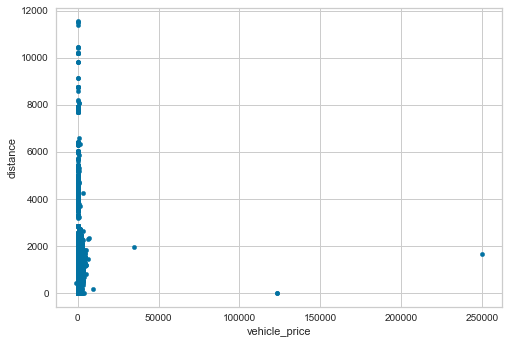

In [89]:
var = 'vehicle_price'
data = pd.concat([df['distance'], df[var]], axis=1)
data.plot.scatter(x=var, y='distance');

In [90]:
df = df[(df['vehicle_price'] < 25000)]

# Build the model

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [36]:
X = df[['vehicle_type', 'distance', 'vehicle_year', 'is_inoperable']] 
y = df['vehicle_price']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,
                                                   random_state = 0)

In [38]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [39]:
regressor.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

# Test and validate the model

In [40]:
predictions = regressor.predict(X_test)

In [41]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true) * 100

In [42]:
y_test = np.array(y_test).reshape(-1,1)

In [43]:
y_test

array([[ 65.],
       [ 90.],
       [ 65.],
       ...,
       [250.],
       [200.],
       [187.]])

In [44]:
predictions = np.array(predictions).reshape(-1,1)

In [45]:
predictions

array([[ 65.        ],
       [ 89.83612861],
       [ 65.        ],
       ...,
       [236.3       ],
       [186.11964711],
       [187.        ]])

In [46]:
mean_absolute_percentage_error(y_test,predictions)

<ipython-input-41-de57bfb3883b>:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean((y_true - y_pred) / y_true) * 100


-inf

In [47]:
mean_absolute_error(y_test, predictions)

31.09320423189839

In [48]:
error_matrix = y_test - predictions
error_list = error_matrix.tolist()

Text(0, 0.5, 'Frequency')

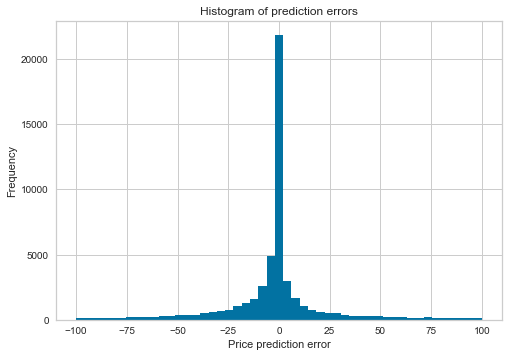

In [49]:
plt.hist(error_matrix, bins = np.linspace(-100,100))
plt.title('Histogram of prediction errors')
plt.xlabel('Price prediction error')
plt.ylabel('Frequency')

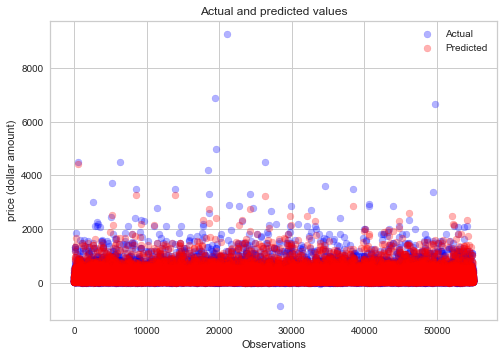

In [50]:
_, ax = plt.subplots()

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, predictions.size), y=predictions, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('price (dollar amount)')
plt.legend()
plt.show()

# Pickle, Package, and (Re)-Test the Model

In [51]:
import pickle

In [52]:
filename = 'sd_rfreg_file.pkl'
outfile = open(filename,'wb')

pickle.dump(regressor,outfile)
outfile.close()

In [53]:
infile = open(filename,'rb')
regressor = pickle.load(infile)

In [54]:
row = X_test[0:1]

In [55]:
row

vehicle_type  distance  vehicle_year  is_inoperable
1217745            10  32.25197          2002              0

In [56]:
regressor.predict(row)

array([65.])

# Test out some API features : preprocessing JSON data

In [124]:
row = df[0:1].drop(columns = ['pickup_coordinates', 'delivery_coordinates', 'distance', 'vehicle_price'])

In [125]:
row['is_inoperable'] = 'f'

In [126]:
row

pickup_latitude  pickup_longitude  delivery_latitude  delivery_longitude  \
35        26.233345        -80.205093          26.687171          -80.182647   

    vehicle_year vehicle_type is_inoperable  
35          2013          suv             f

In [127]:
row.to_json('sample_row.json')

In [1]:
import json

In [6]:
row = pd.read_json('sample_row.json')

In [9]:
pd.DataFrame(row)

pickup_latitude  pickup_longitude  delivery_latitude  delivery_longitude  \
35        26.233345        -80.205093          26.687171          -80.182647   

    vehicle_year vehicle_type is_inoperable  
35          2013          suv             f

In [173]:
def pairs_coordinates(latitude, longitude):
        return (latitude.iloc[0], longitude.iloc[0]) 

In [174]:
pairs_coordinates(row['pickup_latitude'], row['pickup_longitude'])

(26.233344800000005, -80.2050934)

In [172]:
row['pickup_latitude'].iloc[0]

26.233344800000005

In [179]:
features = df.drop(columns = ['vehicle_price', 'pickup_coordinates', 'delivery_coordinates','distance'], axis = 1).columns
pickle.dump(features, open('features.pkl', 'wb'))

In [180]:
features

Index(['pickup_latitude', 'pickup_longitude', 'delivery_latitude',
       'delivery_longitude', 'vehicle_year', 'vehicle_type', 'is_inoperable'],
      dtype='object')